# Spectral Gap Calculation and Plotting Tutorial

This notebook provides a step-by-step guide on how to perform spectral gap calculations and visualize the results. We will use the `spectralgapAnalyser` class to analyze the spectral properties of causal sets. Check spectralgap.py for the code

## Imports


In [1]:
from spectralgapanalyser import SpectralGapAnalyser
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit


/mnt/c/Users/Stuart Ferguson/OneDrive - University of Edinburgh/Documents/PhD/CODE/CST/SamplingCausalSets/SamplingCausalSets/.venv/lib/python3.13/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


## Parameters

Define the parameters for our spectral gap analysis. These parameters control the size of the causal sets, the sampling methods, and other simulation details.

In [55]:
cardinalities = [3, 4, 5,6] # cardinalities to analyze
dimension = 4 # Bd action dimension
epsilon = 0.1 # Parameter of smeared bd action
temp = 1 # Temperature of markov chain (only required when sampling BD-action, not in uniform sampling)
uniform_sampling = True # Set to True for uniform sampling, False for BD sampling


# Set quantum algorithm hyperparameters
TC_gamma_ratio = (0.7,0.8)#(0.7, 0.9) 
BD_gamma_ratio = (0,0)#(0.05, 0.2) 
t = (3, 10) # Time parameter range

colours = ["violet", "g", "lightblue"] # Colors for plotting
methods = ["quantum", "classical", "quantum"] # Sampling methods to compare
method_labels = ["Quantum (1 qubit)", "Classical", "Quantum (2 qubits)"] # Labels for plotting

## Spectral Gap Analyser

Create an instance of the `SpectralGapAnalyser` class. This object will handle the calculations.

In [56]:
specgapanalyser = SpectralGapAnalyser()



The `qc_args` list specifies the arguments for the quantum and classical sampling methods. This allows for flexible configuration of the `compare_gammas` method.

## Perform Spectral Gap Analysis

Iterate through different cardinalities and calculate the spectral gaps for each method. The results (spectral gaps, analyses, and errors) are stored in NumPy arrays.

In [ ]:
deltases = np.zeros((len(cardinalities), len(methods)))
analyses = np.zeros((len(cardinalities), len(methods), 3))
errses = np.zeros((len(cardinalities), len(methods)))

# Loop through cardinalities
for i , c in enumerate(cardinalities):
    print(f"Starting analysis of cardinality: {c}")
    # The how_many_samples_if_sampling parameter controls the number of samples for the analysis.
    # Adjust this value based on computational resources and desired accuracy.
    qc_args = [
            {"gamma_ratios":[TC_gamma_ratio, BD_gamma_ratio], "t":t, "num_qubits": 1},
            {"link_move":True, "relation_move":True},
            {"gamma_ratios":[TC_gamma_ratio, BD_gamma_ratio], "t":t, "num_qubits": 2},
            ]
    deltas, analys, errs = specgapanalyser.compare_gammas(c, temp, methods = methods, qc_args = qc_args, uniform = uniform_sampling, how_many_samples_if_sampling = 10, epsilon = epsilon, dimension = dimension)
    deltases[i,:] = deltas
    analyses[i,:,:] = analys
    errses[i,:] = errs

print("Spectral gap analysis complete.")

Starting analysis of cardinality: 3


 ... (more hidden) ...
 ... (more hidden) ...


Starting analysis of cardinality: 4


 ... (more hidden) ...
 ... (more hidden) ...


Starting analysis of cardinality: 5


 ... (more hidden) ...
 ... (more hidden) ...


Starting analysis of cardinality: 6


## Plotting Spectral Gaps

Now, let's visualize the spectral gaps as a function of cardinality. We will also attempt to fit an exponential decay curve to the data.

Fitting parameters for Quantum (1 qubit): a=0.3275, b=-0.1420
Fitting parameters for Classical: a=1.1840, b=0.4739
Fitting parameters for Quantum (2 qubits): a=0.7678, b=0.0180


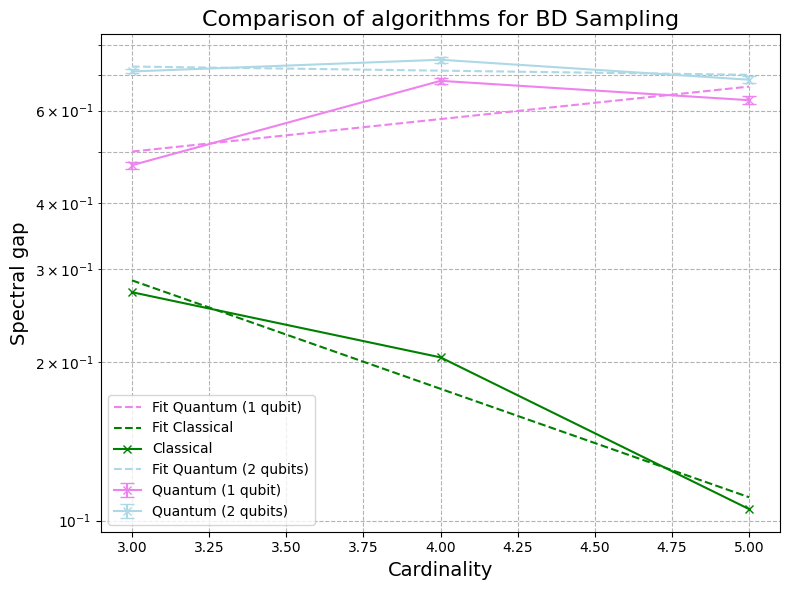

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

popts = []
for i, label in enumerate(method_labels):
    yerr = errses[:, i]

    # Fit an exponential curve to the spectral gaps
    weights =  deltases[:, i]  
    try:
        popt, _ = curve_fit(exponential_decay, cardinalities, deltases[:, i], maxfev=10000, p0=[1, 0.1], sigma=weights)
        a, b = popt
        popts.append(popt)
        print(f"Fitting parameters for {label}: a={a:.4f}, b={b:.4f}")
        
        # Check if the fit parameters are significantly different from initial guess
        if np.isclose(a, 1, rtol=0.01) and np.isclose(b, 0.1, rtol=0.01):
            print(f"Warning: Fitting parameters for {label} were not found or are close to initial guess.")
        else:
            x_fit = np.linspace(min(cardinalities), max(cardinalities), 100)
            y_fit = exponential_decay(x_fit, *popt)
            ax.plot(x_fit, y_fit, linestyle="--", color=colours[i], label=f"Fit {label}")
    except RuntimeError as e:
        print(f"Could not fit exponential curve for {label}: {e}")
        
    # Plot the spectral gaps with error bars if available
    if np.isfinite(yerr).all():
        ax.errorbar(cardinalities, deltases[:, i], yerr=yerr, label=label, marker="x", color=colours[i], capsize=5)
    else:
        ax.plot(cardinalities, deltases[:, i], label=label, marker="x", color=colours[i])

# Add a dummy plot for the 'fit' label in the legend if no fits were successful
if not any([len(p) > 0 for p in popts]):
    ax.plot([], [], linestyle="--", label = "fit", color="k")

#handles, labels = ax.get_legend_handles_labels()
#sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: x[0] == "fit")
#sorted_labels, sorted_handles = zip(*sorted_handles_labels)
#plt.legend(sorted_handles, sorted_labels)
plt.legend()
ax.set_title("Comparison of algorithms for BD Sampling", fontsize=16)
ax.set_xlabel("Cardinality", fontsize=14)
ax.set_ylabel("Spectral gap", fontsize=14)
ax.set_yscale("log")
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()